## Class08

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style='ticks',palette='Set2')

In [2]:
file_path = '/Users/ml/Google Drive/af/teaching/database/data/'
ff3 = pd.read_csv(file_path+'ff_factors.csv',header=0,names=['date','mktrf','smb','hml','rf'])
ff3.head()

,date,mktrf,smb,hml,rf
0,192607,2.96,-2.30,-2.87,0.22
1,192608,2.64,-1.40,4.19,0.25
2,192609,0.36,-1.32,0.01,0.23
3,192610,-3.24,0.04,0.51,0.32
4,192611,2.53,-0.20,-0.35,0.31


In [3]:
port25 = pd.read_csv(file_path+'25portfolios.csv')
port25.columns = [i.lower().replace(' ','') for i in port25.columns]
port25 = port25.rename(columns={'smalllobm':'me1bm1','smallhibm':'me1bm5','biglobm':'me5bm1','bighibm':'me5bm5'})
port25.head()

,date,me1bm1,me1bm2,me1bm3,me1bm4,me1bm5,me2bm1,me2bm2,me2bm3,me2bm4,...,me4bm1,me4bm2,me4bm3,me4bm4,me4bm5,me5bm1,me5bm2,me5bm3,me5bm4,me5bm5
0,192607,3.78,-0.41,-1.94,0.35,2.05,2.19,2.42,0.49,-1.58,...,1.59,1.53,1.19,0.27,2.47,3.45,6.09,2.03,3.11,0.56
1,192608,-2.21,-8.73,2.44,0.61,8.40,2.17,-1.18,4.01,0.46,...,1.33,3.87,2.01,2.17,5.34,1.01,4.19,2.01,5.48,7.76
2,192609,-6.21,-0.30,-6.20,-1.64,0.86,-1.85,-1.26,1.08,-3.04,...,1.09,-0.53,-1.73,1.46,0.87,-1.29,3.65,0.10,-0.75,-2.43
3,192610,-8.62,-3.75,-5.67,5.72,-2.55,-1.80,-3.27,-5.07,-8.05,...,-3.34,-2.66,-2.03,-3.11,-5.35,-2.74,-3.01,-2.24,-4.67,-5.81
4,192611,3.47,6.65,2.26,-4.70,0.54,2.91,-2.37,3.01,4.66,...,3.44,2.39,3.74,4.93,1.82,4.29,2.53,1.52,3.66,2.56


In [4]:
port25_1 = pd.melt(port25,id_vars='date',value_vars=port25.columns[1:])
port25_1.columns = ['date','port','ret']
port25_2 = port25_1[['port','date','ret']].merge(ff3,how='inner',on='date')
port25_2['retx'] = port25_2['ret'] - port25_2['rf']
port25_2 = port25_2.sort_values(['port','date']).reset_index(drop=True)
port25_2.head(10)

,port,date,ret,mktrf,smb,hml,rf,retx
0,me1bm1,192607,3.78,2.96,-2.30,-2.87,0.22,3.56
1,me1bm1,192608,-2.21,2.64,-1.40,4.19,0.25,-2.46
2,me1bm1,192609,-6.21,0.36,-1.32,0.01,0.23,-6.44
3,me1bm1,192610,-8.62,-3.24,0.04,0.51,0.32,-8.94
4,me1bm1,192611,3.47,2.53,-0.20,-0.35,0.31,3.16
5,me1bm1,192612,13.95,2.62,-0.04,-0.02,0.28,13.67
6,me1bm1,192701,0.45,-0.06,-0.56,4.83,0.25,0.20
7,me1bm1,192702,2.49,4.18,-0.10,3.17,0.26,2.23
8,me1bm1,192703,6.40,0.13,-1.60,-2.67,0.30,6.10
9,me1bm1,192704,5.84,0.46,0.43,0.60,0.25,5.59


### Define function to estimate $\alpha$

In [5]:
def ols_reg(reg_data,x):
    df = reg_data.copy()
    b = sm.OLS(df['retx'],sm.add_constant(df[x]),missing='drop').fit().params
    b.index = ['alpha']+['b_'+i for i in x]
    t = sm.OLS(df['retx'],sm.add_constant(df[x]),missing='drop').fit().tvalues
    t.index = ['t_'+i for i in ['alpha']+x]
    r2 = pd.Series(sm.OLS(df['retx'],sm.add_constant(df[x]),missing='drop').fit().rsquared,index=['adj. R2'])
    est = pd.concat([b,t,r2])
    return est

### Define function to highlight $\alpha$ with t value greater than 2

In [6]:
def sig_style(t):
    sig_id = t.abs() >= 2
    return ['background-color: yellow' if i else '' for i in sig_id]

### CAPM

#### CAPM before 1965

In [7]:
capm_bef_mean = port25_2[port25_2['date']<196501].groupby('port')['retx'].aggregate(['count','mean','std'])
capm_bef_est = port25_2[port25_2['date']<196501].groupby('port').apply(ols_reg,['mktrf'])
capm_bef = capm_bef_mean.join(capm_bef_est)
capm_bef.style.apply(sig_style,subset=['t_alpha'])

,count,mean,std,alpha,b_mktrf,t_alpha,t_mktrf,adj. R2
port,,,,,,,,
me1bm1,462,1.01236,16.3199,-0.511967,1.76443,-0.921565,20.4194,0.475457
me1bm2,462,0.552706,12.7682,-0.764265,1.52442,-1.96462,25.1937,0.579803
me1bm3,462,1.27628,11.9034,-0.0609646,1.54788,-0.195026,31.8351,0.687812
me1bm4,462,1.39701,10.9317,0.160258,1.43157,0.567168,32.573,0.697567
me1bm5,462,1.72545,12.4137,0.354985,1.58634,1.04999,30.1666,0.66424
me2bm1,462,0.799113,8.89985,-0.215435,1.17436,-0.953457,33.4148,0.708223
me2bm2,462,1.14232,9.13707,0.0538482,1.25992,0.263411,39.6241,0.773407
me2bm3,462,1.15106,9.14801,0.0354146,1.29138,0.189245,44.3659,0.810569
me2bm4,462,1.26258,9.61191,0.100078,1.34561,0.491887,42.5207,0.797179


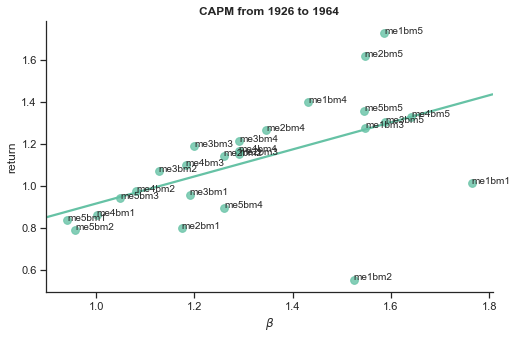

In [8]:
plt.figure(figsize=(8,5))
ax1 = sns.regplot(x='b_mktrf', y='mean', data=capm_bef,scatter_kws={"s": 60},ci=None)
for i, txt in enumerate(capm_bef.index):
    ax1.annotate(txt, (capm_bef['b_mktrf'][i], capm_bef['mean'][i]))

plt.xlabel(r'$\beta$')
plt.ylabel('return')
plt.title('CAPM from 1926 to 1964',fontweight='bold')
sns.despine()
plt.show()

#### CAPM after 1965

In [9]:
capm_aft_mean = port25_2[port25_2['date']>=196501].groupby('port')['retx'].aggregate(['count','mean','std'])
capm_aft_est = port25_2[port25_2['date']>=196501].groupby('port').apply(ols_reg,['mktrf'])
capm_aft = capm_aft_mean.join(capm_aft_est)
capm_aft.style.apply(sig_style,subset=['t_alpha'])

,count,mean,std,alpha,b_mktrf,t_alpha,t_mktrf,adj. R2
port,,,,,,,,
me1bm1,631,0.254786,7.99574,-0.468746,1.42729,-2.41226,32.9144,0.63267
me1bm2,631,0.796292,6.97278,0.168547,1.23834,0.986018,32.4629,0.626227
me1bm3,631,0.791125,6.03187,0.22959,1.10773,1.65146,35.7052,0.669619
me1bm4,631,1.03013,5.74851,0.510699,1.02466,3.64649,32.7851,0.630839
me1bm5,631,1.0913,6.04811,0.550703,1.06642,3.67056,31.8516,0.617285
me2bm1,631,0.511823,7.24859,-0.199069,1.40236,-1.3514,42.6605,0.743152
me2bm2,631,0.768463,6.02328,0.171509,1.1776,1.44625,44.4977,0.758915
me2bm3,631,0.868542,5.46485,0.332494,1.05745,2.99545,42.6898,0.743414
me2bm4,631,0.933106,5.28058,0.419274,1.01363,3.82187,41.4039,0.731573


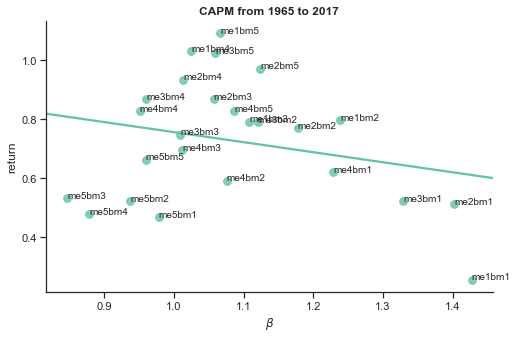

In [10]:
plt.figure(figsize=(8,5))
ax1 = sns.regplot(x='b_mktrf', y='mean', data=capm_aft,scatter_kws={"s": 60},ci=None)
for i, txt in enumerate(capm_aft.index):
    ax1.annotate(txt, (capm_aft['b_mktrf'][i], capm_aft['mean'][i]))

plt.xlabel(r'$\beta$')
plt.ylabel('return')
plt.title('CAPM from 1965 to 2017',fontweight='bold')
sns.despine()
plt.show()

### Fama-French 3-factor model

In [11]:
ff3_mean = port25_2.groupby('port')['retx'].aggregate(['count','mean','std'])
ff3_est = port25_2.groupby('port').apply(ols_reg,['mktrf','smb','hml'])
factor3_mean = ff3[['mktrf','smb','hml']].mean()
ff3_fitted = ff3_est['b_mktrf']*factor3_mean[0]+ff3_est['b_smb']*factor3_mean[1]+ff3_est['b_hml']*factor3_mean[2]
ff3_fitted = pd.DataFrame(ff3_fitted,columns=['fitted'])
ff3_a = ff3_mean.join(ff3_est).join(ff3_fitted)
ff3_a.style.apply(sig_style,subset=['t_alpha'])

,count,mean,std,alpha,b_mktrf,b_smb,b_hml,t_alpha,t_mktrf,t_smb,t_hml,adj. R2,fitted
port,,,,,,,,,,,,,
me1bm1,1093,0.575005,12.2255,-0.735795,1.28953,1.43633,0.427336,-3.3456,29.3861,20.004,6.6591,0.65506,1.3108
me1bm2,1093,0.69333,9.84319,-0.422258,1.07956,1.53613,0.226445,-3.30391,42.334,36.8148,6.07213,0.820305,1.11559
me1bm3,1093,0.996194,8.99245,-0.153679,1.05466,1.24115,0.51509,-1.67141,57.4877,41.3461,19.199,0.888566,1.14987
me1bm4,1093,1.18521,8.33944,0.0879211,0.945476,1.22384,0.574061,1.27227,68.5694,54.2447,28.4691,0.926808,1.09728
me1bm5,1093,1.35935,9.28747,0.0872788,0.987676,1.30421,0.91106,1.24054,70.3574,56.7797,44.3791,0.938834,1.27207
me2bm1,1093,0.633257,7.98569,-0.226136,1.08628,1.1253,-0.227412,-3.03301,73.0192,46.2291,-10.4531,0.907087,0.859393
me2bm2,1093,0.926487,7.49729,0.00143054,1.01927,0.978575,0.134653,0.0236134,84.3218,49.4763,7.61735,0.930405,0.925056
me2bm3,1093,0.98796,7.25107,0.0335085,0.98421,0.832513,0.348314,0.593049,87.3004,45.1306,21.1269,0.935281,0.954451
me2bm4,1093,1.07237,7.42406,0.0481492,0.969332,0.812167,0.564793,0.948704,95.721,49.0153,38.1382,0.950187,1.02422


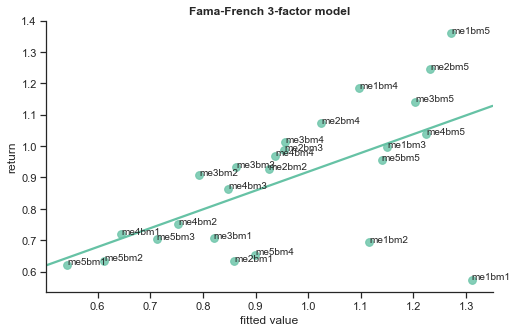

In [12]:
plt.figure(figsize=(8,5))
ax1 = sns.regplot(x='fitted', y='mean', data=ff3_a,scatter_kws={"s": 60},ci=None)
for i, txt in enumerate(ff3_a.index):
    ax1.annotate(txt, (ff3_a['fitted'][i], ff3_a['mean'][i]))

plt.xlabel('fitted value')
plt.ylabel('return')
plt.title('Fama-French 3-factor model',fontweight='bold')
sns.despine()
plt.show()

### Fama-French 5-factor model

In [13]:
ff5 = pd.read_csv(file_path+'ff5.csv',header=0,names=['date','mktrf','smb','hml','rmw','cma','rf'])
port25_3 = port25_1[['port','date','ret']].merge(ff5,how='inner',on='date')
port25_3['retx'] = port25_3['ret'] - port25_3['rf']
port25_3 = port25_3.sort_values(['port','date']).reset_index(drop=True)
port25_3.head(10)

,port,date,ret,mktrf,smb,hml,rmw,cma,rf,retx
0,me1bm1,196307,0.85,-0.39,-0.46,-0.81,0.72,-1.16,0.27,0.58
1,me1bm1,196308,3.80,5.07,-0.81,1.63,0.42,-0.40,0.25,3.55
2,me1bm1,196309,-2.70,-1.57,-0.48,0.19,-0.80,0.23,0.27,-2.97
3,me1bm1,196310,1.36,2.53,-1.29,-0.11,2.75,-2.26,0.29,1.07
4,me1bm1,196311,-3.11,-0.85,-0.84,1.66,-0.34,2.22,0.27,-3.38
5,me1bm1,196312,-2.94,1.83,-1.87,-0.11,0.18,-0.31,0.29,-3.23
6,me1bm1,196401,3.95,2.24,0.09,1.64,0.21,1.51,0.30,3.65
7,me1bm1,196402,3.14,1.54,0.30,2.83,0.04,0.87,0.26,2.88
8,me1bm1,196403,0.63,1.41,1.42,3.36,-2.00,2.95,0.31,0.32
9,me1bm1,196404,-1.70,0.10,-1.51,-0.42,-1.40,-1.10,0.29,-1.99


In [14]:
ff5_mean = port25_3.groupby('port')['retx'].aggregate(['count','mean','std'])
ff5_est = port25_3.groupby('port').apply(ols_reg,['mktrf','smb','hml','rmw','cma'])
factor5_mean = ff5[['mktrf','smb','hml','rmw','cma']].mean()
ff5_fitted = ff5_est['b_mktrf']*factor5_mean[0]+ff5_est['b_smb']*factor5_mean[1] \
    +ff5_est['b_hml']*factor5_mean[2]+ff5_est['b_rmw']*factor5_mean[3]+ff5_est['b_cma']*factor5_mean[4]
ff5_fitted = pd.DataFrame(ff3_fitted,columns=['fitted'])
ff5_a = ff5_mean.join(ff5_est).join(ff5_fitted)
ff5_a.style.apply(sig_style,subset=['t_alpha'])

,count,mean,std,alpha,b_mktrf,b_smb,b_hml,b_rmw,b_cma,t_alpha,t_mktrf,t_smb,t_hml,t_rmw,t_cma,adj. R2,fitted
port,,,,,,,,,,,,,,,,,
me1bm1,649,0.25624,7.89372,-0.293284,1.03625,1.2542,-0.405826,-0.497763,-0.149549,-3.37326,48.0975,41.8746,-9.76735,-12.0852,-2.42547,0.928932,1.3108
me1bm2,649,0.782804,6.88487,0.11658,0.939015,1.23202,-0.133309,-0.357649,-0.000604481,1.77886,57.8213,54.5701,-4.2565,-11.5198,-0.0130063,0.946919,1.11559
me1bm3,649,0.789168,5.95803,-0.0209894,0.930285,1.07828,0.114045,-0.0261291,0.0666431,-0.39548,70.7357,58.976,4.49653,-1.03924,1.77065,0.953515,1.14987
me1bm4,649,1.01086,5.67813,0.181215,0.876355,1.05623,0.264676,-0.0274956,0.0702625,3.31951,64.7826,56.164,10.1454,-1.06319,1.81492,0.945851,1.09728
me1bm5,649,1.0955,5.97626,0.124763,0.962591,1.06996,0.481495,0.006954,0.100096,2.1615,67.2991,53.8095,17.4557,0.254316,2.44534,0.945353,1.27207
me2bm1,649,0.494961,7.15986,-0.0841641,1.09609,0.981118,-0.45562,-0.158381,-0.144976,-1.34032,70.4411,45.3548,-15.1831,-5.32418,-3.25559,0.95494,0.859393
me2bm2,649,0.755408,5.95151,-0.0357027,1.01727,0.92252,-0.0237563,0.0913917,0.0464839,-0.670205,77.0625,50.2694,-0.933174,3.62146,1.23045,0.953065,0.925056
me2bm3,649,0.881294,5.39663,0.00630738,0.977145,0.827638,0.256573,0.219641,0.0452467,0.121754,76.1185,46.3761,10.3638,8.94983,1.23161,0.946018,0.954451
me2bm4,649,0.92869,5.21801,0.0277864,0.975023,0.737537,0.430726,0.132746,0.0813331,0.565444,80.0701,43.5674,18.3415,5.70226,2.33388,0.948044,1.02422


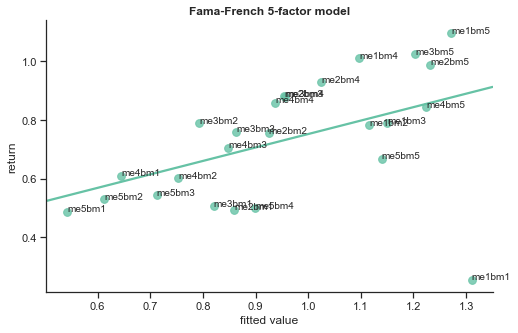

In [15]:
plt.figure(figsize=(8,5))
ax1 = sns.regplot(x='fitted', y='mean', data=ff5_a,scatter_kws={"s": 60},ci=None)
for i, txt in enumerate(ff5_a.index):
    ax1.annotate(txt, (ff5_a['fitted'][i], ff5_a['mean'][i]))

plt.xlabel('fitted value')
plt.ylabel('return')
plt.title('Fama-French 5-factor model',fontweight='bold')
sns.despine()
plt.show()